In [3]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt

In [7]:
h = 0.15
center1 = (1.75, 0, 0)
center2 = (-1.75, 0, 0)

sphere1 = bempp.api.shapes.sphere(h=h, origin=center1)
sphere2 = bempp.api.shapes.sphere(h=h, origin=center2)

rwg1 = bempp.api.function_space(sphere1, "RWG", 0)
rwg2 = bempp.api.function_space(sphere2, "RWG", 0)

snc1 = bempp.api.function_space(sphere1, "SNC", 0)
snc2 = bempp.api.function_space(sphere2, "SNC", 0)

In [8]:
N = 20  # number of quadrature points
lbound = .005
ubound = 10

# We use an exponentially adapted trapezoid rule.
quad_points = np.linspace(np.exp(-ubound), np.exp(-lbound), N)
results = np.empty(N, dtype='float64')

We are defining an exponentially adapted trapezoid rule and choose the quadrature points accordingly.

In [9]:
for index, point in enumerate(quad_points):
    
    wavenumber = -1j * np.log(point)

    op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg1, snc1, wavenumber)
    op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg2, snc2, wavenumber)
    op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg2, snc2, wavenumber)
    op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg1, snc1, wavenumber)
    
    mat11 = op11.weak_form().A
    mat12 = op12.weak_form().A
    mat21 = op21.weak_form().A
    mat22 = op22.weak_form().A
    mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
    mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

    mat = np.block([[mat11,mat12],[mat21,mat22]])  
    mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
    mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))

    inv_free_mat2 = np.block([[mat11_inv,  mat12_zero],
                          [mat21_zero, mat22_inv]])  

    combined_inverse_free = inv_free_mat2.dot(mat)
    sign, logdet = slogdet(combined_inverse_free)
    results[index] = logdet
    print(f"Log Determinant: {index}: {logdet}")

Log Determinant: 0: 6.692424392440443e-13
Log Determinant: 1: -9.518597271303642e-06
Log Determinant: 2: -6.956477937820622e-05
Log Determinant: 3: -0.00021604335504805976
Log Determinant: 4: -0.0004711469502304588
Log Determinant: 5: -0.0008438372877825626
Log Determinant: 6: -0.001330200028322496
Log Determinant: 7: -0.0019142500965479464
Log Determinant: 8: -0.0025695342380566387
Log Determinant: 9: -0.003261755447084207
Log Determinant: 10: -0.003952472013281915
Log Determinant: 11: -0.004603673341495227
Log Determinant: 12: -0.005182722812006864
Log Determinant: 13: -0.0056668419824795245
Log Determinant: 14: -0.0060460931653498655
Log Determinant: 15: -0.006323828278902894
Log Determinant: 16: -0.006513952339566303
Log Determinant: 17: -0.006635194055345141
Log Determinant: 18: -0.006703927222194892
Log Determinant: 19: -0.006728912663845932


The left plot shows the relative log determinant with increasing imaginary wavenumber. The right plot uses a scale appropriate for the trapezoid quadrature rule.

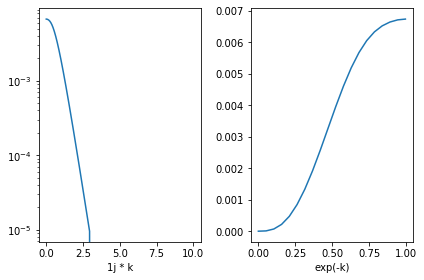

In [10]:
%matplotlib inline
from matplotlib.pyplot import figure

fig = figure()
ax1 = fig.add_subplot(121)
ax1.set_xlabel('1j * k')
ax2 = fig.add_subplot(122)
ax2.set_xlabel('exp(-k)')
ax1.semilogy(-np.log(quad_points), -results)
ax2.plot(quad_points, -results)
fig.tight_layout()

In [11]:
casimir_energy = np.trapz(-results / quad_points, quad_points) / (2 * np.pi)
print(f"The normalized Casimir Energy is: {casimir_energy}")

The normalized Casimir Energy is: 0.0008694834909084946
